In [101]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.callbacks import TensorBoard

import multiprocessing
from multiprocessing import Pool
from functools import partial
%matplotlib inline

def clear_line():
    print(' '*80,end='\r')
    
#function to get activation of input data into a list
def get_activation(data, get_layer_output_functions): 
    layer_output = []
    for f in get_layer_output_functions[:-1]:
        layer_output.append(f(data.reshape(1,2))[0])

    for i in range(len(layer_output)):
        #layer_nonzero_index = np.flatnonzero(layer_output[i])
        layer_output[i][np.flatnonzero(layer_output[i])] = 1
        layer_output[i] = layer_output[i].astype(int)
        
    act_list = layer_output
    return act_list

#assign a different color to each different activation,use color index
def assign_color(hid_layer_units,activations,act_index):
    color_index = 0
    for i in range(len(hid_layer_units)):
        binary = ''.join(str(e) for e in activations[act_index][i].astype(int))
        color_index+=int(binary,2)
    return color_index

def prepare_model(hid_layer_units, n_category):
    model = tf.keras.Sequential()
    for i in range(len(hid_layer_units)):
        if i == 0:
            model.add(Dense(hid_layer_units[i], input_shape=(2,), activation='relu',bias_initializer='random_uniform'))
        else:
            model.add(Dense(hid_layer_units[i], activation='relu',bias_initializer='random_uniform'))
    model.add(Dense(n_category, activation='softmax',bias_initializer='random_uniform'))
    # Configure a model for categorical classification.
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=[tf.keras.metrics.categorical_accuracy])
    return model

def data_grid(grid, square_len):
    k = square_len
    x = np.linspace(-k,k,grid+1)
    y = np.linspace(-k,k,grid+1) 

    xv,yv = np.meshgrid( x , y )
    data = np.array([xv.flatten(),yv.flatten()])
    data = data.transpose()
    return data

def get_color(data):
    interval = int(np.ceil(255/len(data)**(1/3.0)))
    R = range(0,255,interval)
    G = range(0,255,interval)
    B = range(0,255,interval)
    rv,gv,bv = np.meshgrid(R,G,B)
    colors = np.array([rv.flatten(),gv.flatten(),bv.flatten()]).transpose()
    np.random.shuffle(colors)
    return colors

def draw_activation(hid_layer_units,num_epoch, colors, plot_style, X_test, model,pool):
    pool = Pool(8)
    for epoch_i in range(num_epoch):
        epoch_info = "epoch:{0} ".format(epoch_i)
        print(epoch_info, end="\r")
        #loop for all data points to get activations
        i_data = 0
        activations = []

        for test_data in X_test:
#             act_progress = "get activation progress:{0}%".format(round((i_data + 1) * 100 / len(X_test)))
#             print(epoch_info+act_progress,end='\r')
            activations.append(get_activation(test_data,get_layer_output_functions))
            i_data = i_data + 1
#         clear_line()

        f = partial(assign_color,hid_layer_units,activations)
        i_color=0
        data_activation_color=[]
        for y in pool.map(f, range(len(activations))):
            i_color+=1
#             color_progress = "get data color progress:{0}%".format(round((i_color + 1) * 100 / len(activations)))
#             print(epoch_info+color_progress,end='\r')
            data_activation_color.append(y)
#         clear_line()

        data_activation_color = np.asarray(data_activation_color)
        data_color_cluster = np.unique(data_activation_color)
        for color_i in range(len(data_activation_color)):
            [data_activation_color[color_i]] = np.where(data_color_cluster == data_activation_color[color_i])[0]
        if plot_style == style[1]:
            data_activation_color = colors[data_activation_color]/255
        data_activation_color = data_activation_color.astype(int)
        
        plt.figure(figsize=(10, 10))
        plt.scatter(X_test[:, 0], X_test[:, 1], marker='o',s=4, c=data_activation_color, linewidths=2,cmap = 'gray')
        plt.title('epoch'+str(format(epoch_i,'0>3'))+'_'+model_name+'_activation',fontsize=20)
        plt.savefig(directory+'/'+'epoch'+str(format(epoch_i,'0>3'))+'_'+model_name+'_activation')
        plt.close()

        step = epoch_i+1
        history = model.fit(data, labels, epochs=1,verbose=0,steps_per_epoch=step,batch_size=batch_size)
        train_info = epoch_info+str(history.history)
        print(train_info, end='\n')
        
        File = open(trainlog_path+'/'+model_name+'.txt','a+') 
        File.write(train_info+'\n')
        File.flush()
        File.close()

## Prepare Data

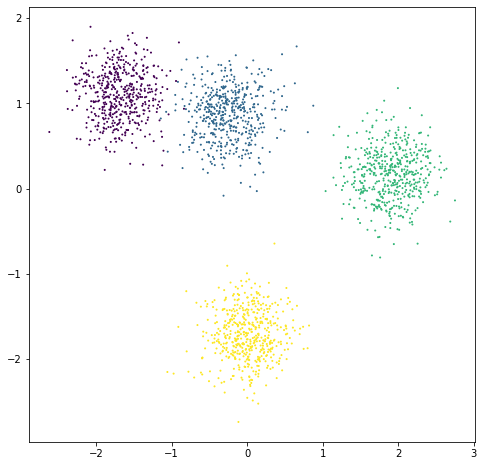

In [102]:
#Prepare data
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical

random_state=7
X, Y = make_blobs(n_samples=2000,n_features=2, cluster_std=0.3,centers=4,center_box=(-2.0, 2.0),random_state=7)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Y, s=1, facecolors='b', linewidths=1, label='Class 1')
plt.show()

data = X
labels = to_categorical(Y)

In [ ]:
import os
from tensorflow.keras import backend as K

first_layer = [4,10,20,30,60]
second_layer = [4,10,20,30,60]

num_epoch = 100
batch_size = 32
X_test = data_grid(grid=200,square_len=6)
colors = get_color(X_test)
pool = Pool(8)

for i in range(len(first_layer)):
    for j in range(len(second_layer)):
        print('hid_layer: [%i , %i]'%(first_layer[i],second_layer[j]))
        print('progress :', (i+j)/(len(first_layer)+len(second_layer)))
        hid_layer_units = [first_layer[i], second_layer[j]]
        model = prepare_model(hid_layer_units, n_category=len(labels[0]))
        
        model_name = '_'.join(str(e) for e in hid_layer_units)+'_2'+'_'+plot_style
        directory = 'iterasive_result/'+'model_'+model_name
        if not os.path.exists(directory):
            os.makedirs(directory)
        #model.save(directory+'/'+'initial'+model_name+'_model.h5') 

        trainlog_path = 'iterasive_result/trainlog'
        if not os.path.exists(trainlog_path):
            os.makedirs(trainlog_path)
            
        get_layer_output_functions = []
        for layer_i in range(len(model.layers)):
            get_layer_output_functions.append(K.function(model.layers[0].input,model.layers[layer_i].output))
                     
        draw_activation(hid_layer_units,num_epoch, colors, plot_style, X_test, model,pool)

pool.close()
pool.join()

hid_layer: [4 , 4]
progress : 0.0
epoch:0 {'loss': [1.3195104598999023], 'categorical_accuracy': [0.1355]}
epoch:1 {'loss': [1.3153072595596313], 'categorical_accuracy': [0.15275]}
epoch:2 {'loss': [1.3083462715148926], 'categorical_accuracy': [0.32116666]}
epoch:3 {'loss': [1.298668771982193], 'categorical_accuracy': [0.42625]}
epoch:4 {'loss': [1.286310076713562], 'categorical_accuracy': [0.4548]}


In [69]:
hid_layer_units = [30,30]
model = prepare_model(hid_layer_units, 4)
for i in range(100):
    step = i+1
    model.fit(data, labels, epochs=1,steps_per_epoch=step,batch_size=32)

W0821 00:55:12.663591 139688749041472 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1 samples
1/1 [==============================] - 0s 117ms/step - loss: 1.4827 - categorical_accuracy: 0.2480
Train on 2 samples
2/2 [==============================] - 0s 6ms/step - loss: 1.4478 - categorical_accuracy: 0.2480
Train on 3 samples
3/3 [==============================] - 0s 5ms/step - loss: 1.3911 - categorical_accuracy: 0.2480
Train on 4 samples
4/4 [==============================] - 0s 6ms/step - loss: 1.3147 - categorical_accuracy: 0.2476
Train on 5 samples
5/5 [==============================] - 0s 5ms/step - loss: 1.2215 - categorical_accuracy: 0.3598
Train on 6 samples
6/6 [==============================] - 0s 6ms/step - loss: 1.1163 - categorical_accuracy: 0.7712
Train on 7 samples
7/7 [==============================] - 0s 6ms/step - loss: 1.0032 - categorical_accuracy: 0.9274
Train on 8 samples
8/8 [==============================] - 0s 5ms/step - loss: 0.8855 - categorical_accuracy: 0.9501
Train on 9 samples
9/9 [==============================] - 0s 5ms/step 

70/70 [==============================] - 0s 5ms/step - loss: 0.0071 - categorical_accuracy: 0.9980
Train on 71 samples
71/71 [==============================] - 0s 5ms/step - loss: 0.0071 - categorical_accuracy: 0.9980
Train on 72 samples
72/72 [==============================] - 0s 5ms/step - loss: 0.0071 - categorical_accuracy: 0.9980
Train on 73 samples
73/73 [==============================] - 0s 6ms/step - loss: 0.0070 - categorical_accuracy: 0.9980
Train on 74 samples
74/74 [==============================] - 0s 5ms/step - loss: 0.0070 - categorical_accuracy: 0.9980
Train on 75 samples
75/75 [==============================] - 0s 5ms/step - loss: 0.0070 - categorical_accuracy: 0.9980
Train on 76 samples
76/76 [==============================] - 0s 5ms/step - loss: 0.0069 - categorical_accuracy: 0.9980
Train on 77 samples
77/77 [==============================] - 0s 5ms/step - loss: 0.0069 - categorical_accuracy: 0.9980
Train on 78 samples
78/78 [==============================] - 0s 5ms/

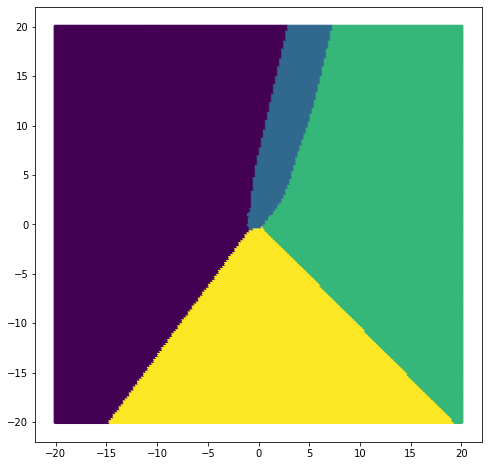

In [95]:
#test
import numpy as np

X_test = data_grid(200,20)
Y_test = model.predict(X_test)
Y_test = np.argmax(Y_test, axis=1)

plt.figure(figsize=(8, 8))
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=Y_test*2, s=10)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y, s=10)
plt.show()
plt.close()

plt.figure(figsize=(12, 12))
for k in range(len(cluster_index)):
    progress += 1
    #print("Progress:{0}%".format(round((progress + 1) * 100 / len(cluster_index))), end="\r")
    plt.scatter(X_test[cluster_index[k], 0], X_test[cluster_index[k], 1], marker='o',s=4, color=colors[data_activation_color[cluster_index[k]][0]]/255.0, linewidths=2)
plt.margins(x=0.1, y=0.1)
plt.show()
plt.savefig('activation')

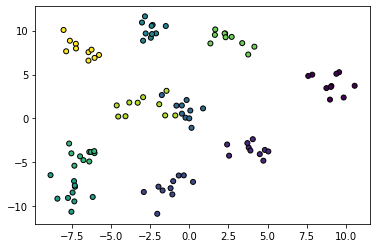

In [8]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles
X1, Y1 = make_blobs(n_features=2, centers=10)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,
            s=25, edgecolor='k')

In [83]:
a = np.zeros((2,4))
a[0,2]=1
a[1,3]=1
np.argmax(a,axis=1)

array([2, 3])